# NEURAL NETWORKS BINARY CLASSIFICATION

бинарная классификация ответов клиента в стиле да/нет на уточняющий вопрос, например "вы уверены, что хотите отменить отправку сообщения?"

Данильченко Вадим

-------------------------------------------------------------------------------------------------------------------------------

In [1]:
import re
import tensorflow
import joblib
import pandas as pd
import numpy as np
from gensim.models import Word2Vec, FastText
from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import trange
from keras.preprocessing.sequence import pad_sequences
from pymorphy2 import MorphAnalyzer
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Input, Concatenate, Dense, Activation, Flatten, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM, Bidirectional, Multiply, add, GRU, Reshape, TimeDistributed, GlobalMaxPooling1D
from keras import regularizers
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
# загрузим все фразы
bazonka = pd.read_excel(r'C:\Users\vndan\projects\netology_chat_bot\kb\kb_new.xlsx', sheet_name='kb')
bazonka.shape

dialogues = joblib.load(r'F:\ОБУЧЕНИЕ\CHAT-BOTs\тексты\dialogues\dialogues_prepared.pkl')
intents = open(r'F:\ОБУЧЕНИЕ\CHAT-BOTs\тексты\dialogues\_intents.txt', encoding='utf-8').readlines()
intents =  [str(i).replace('\n', '') for i in intents]
phrases = open(r'F:\ОБУЧЕНИЕ\CHAT-BOTs\тексты\dialogues\_phrases.txt', encoding='utf-8').readlines()
phrases =  [str(i).replace('\n', '') for i in phrases]
yes_no = pd.read_excel(r'C:\Users\vndan\projects\netology_chat_bot\kb\train_data_yes.xlsx')
# объединим все диалоги в один список
concatted_phrases = dialogues.participant_1.tolist() + dialogues.participant_2.tolist() + intents + phrases + bazonka['message'].tolist() + yes_no['message'].tolist()
concatted_phrases = intents + phrases + bazonka['message'].tolist() + yes_no['message'].tolist()
concatted_phrases[620:655]

['привет как настроение',
 'привет как настроеньице',
 'привет как поживаешь',
 'привет как твои дела',
 'привет как ты',
 'привет как ты чем занимаешься',
 'привет как у вас дела',
 'привет как у тебя дела',
 'привет привет как делишки',
 'приветик как дела',
 'приветики как дела',
 'сам как',
 'тоже не плохо',
 'ты как',
 'у меня все хорошо а у тебя',
 'узнать как дела',
 'че как',
 'эээй привет как дела ты откуда',
 'будет ли сегодня дождь',
 'какая погода завтра',
 'погода',
 'завтра какая погода',
 'завтра солнечно',
 'какая погода',
 'метеопрогноз',
 'метеопрогноз на сегодня',
 'прогноз погоды',
 'прогноз погоды на сегодня',
 'сегодня солнечно',
 'сколько градусов',
 'температуру можешь сказать',
 'узнать метеопрогноз на сегодня',
 'узнать погоду',
 'что за окном',
 'метеопрогноз на завтра']

In [4]:
# токенизируем
def text2seq(phrase):
    phrase = re.sub('ё', 'е', phrase)
    return text_to_word_sequence(str(phrase), filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')

text = [text2seq(phrase) for phrase in concatted_phrases]
text[:2]

[['поприветствовать', 'бота'], ['поприветствовать', 'бота']]

In [5]:
# лемматизируем
morph = MorphAnalyzer()
sentences = [[] for _ in range(len(text))]
for sentence in trange(len(text)):
    phrase = text[sentence]
    for word in phrase:
        sentences[sentence].append(morph.parse(word)[0].normal_form)

100%|██████████| 928/928 [00:00<00:00, 1895.02it/s]


подготвока эмбеддингов

In [6]:
# обучим модели
size = 50
window = 5
ft = FastText(sentences=sentences, size=size, window=window, min_count=1, seed=777, workers=-1, max_vocab_size=None)
wvec = Word2Vec(sentences=sentences, size=size, window=window, min_count=1, seed=777, workers=-1, max_vocab_size=None)

In [7]:
wvec.wv.__getitem__('email')

array([ 0.00611621,  0.00200438,  0.00116524, -0.00796932,  0.00013929,
        0.00214457, -0.00595295,  0.00688333, -0.00548837, -0.00189744,
        0.00107422, -0.00948962, -0.00134924, -0.00644227, -0.00347252,
        0.00653213,  0.00265306, -0.00822747,  0.00052185, -0.00316316,
        0.00584888,  0.00821538, -0.00747785,  0.00273563, -0.0067853 ,
        0.00723975, -0.0035226 ,  0.00570089,  0.00944334, -0.00336898,
       -0.00788026, -0.00600807,  0.00498362,  0.00347864, -0.00562395,
       -0.00182934, -0.00749047,  0.00628384,  0.00970353,  0.00984273,
        0.00921473, -0.00641799, -0.00202979,  0.00906176,  0.00481646,
        0.0052074 ,  0.00885694, -0.00552878, -0.00164396, -0.00995689],
      dtype=float32)

In [8]:
# функция, объединяющая результаты моделей в один вектор
def get_item(word):
    if word in wvec:
        w = wvec.wv.__getitem__(word)
    else:
        w = np.zeros(wvec.wv.vector_size)
    if word in ft:
        f = ft.wv.__getitem__(word)
    else:
        f = np.zeros(ft.wv.vector_size)
    return np.concatenate([w,f])

get_item('email')

array([ 6.1162105e-03,  2.0043831e-03,  1.1652398e-03, -7.9693208e-03,
        1.3928728e-04,  2.1445735e-03, -5.9529515e-03,  6.8833292e-03,
       -5.4883733e-03, -1.8974403e-03,  1.0742204e-03, -9.4896220e-03,
       -1.3492433e-03, -6.4422749e-03, -3.4725249e-03,  6.5321252e-03,
        2.6530649e-03, -8.2274703e-03,  5.2184932e-04, -3.1631638e-03,
        5.8488813e-03,  8.2153808e-03, -7.4778521e-03,  2.7356318e-03,
       -6.7853006e-03,  7.2397538e-03, -3.5226003e-03,  5.7008923e-03,
        9.4433352e-03, -3.3689770e-03, -7.8802574e-03, -6.0080672e-03,
        4.9836249e-03,  3.4786426e-03, -5.6239483e-03, -1.8293411e-03,
       -7.4904710e-03,  6.2838360e-03,  9.7035328e-03,  9.8427264e-03,
        9.2147263e-03, -6.4179855e-03, -2.0297901e-03,  9.0617565e-03,
        4.8164558e-03,  5.2074045e-03,  8.8569401e-03, -5.5287820e-03,
       -1.6439577e-03, -9.9568851e-03, -2.1878562e-03,  1.2443402e-03,
       -5.7335729e-03, -4.1821520e-03,  4.0046623e-05, -3.0518495e-03,
      

In [9]:
# создадим словарь индексов слов
id2word = {k+1:v for k,v in enumerate(list(wvec.wv.vocab.keys()))}

# на всякий случай проверим и добавим словарь fasttext
i = max(id2word)
for word in list(ft.wv.vocab.keys()):
    if word not in id2word.values():
        i+=1
        id2word[i] = word

# добавим UNK, в него будут преобразовываться все неизвестные слова
id2word[0] ='UNK'

# также словарь слов в индекс
word2id = {v: k for k, v in id2word.items()}

In [10]:
# функция преобразования входящей фразы в вектор
def vectorize(phrase):
    phrase = ' '.join(text2seq(phrase))
    vector_tmp = []
    for word in phrase:
        word = morph.parse(word)[0].normal_form
        if word not in word2id:
            word = 'UNK'
        vector_tmp.append(get_item(word))
    return np.mean(vector_tmp, axis=0)

подготовим модель

In [18]:
# объявим гиперпараметры дальнейшей модели
MAX_SEQ_LEN = 8
# MAX_VOCAB_SIZE = len(wvec.wv.vocab)+1
MAX_VOCAB_SIZE = len(id2word)+1
EMBEDDING_DIM = len(get_item('привет'))
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 18
EPOCHS = 10
CLASSES = 2

подготовим данные для обучения

In [12]:
# немного измененная функция векторизации
def preprocess(text):
    temp_seq = []
    # text = ' '.join([word for word in morph.lemmatize(text) if not any(i in word for i in [' ', '\n'])])
    for word in text2seq(str(text)):
        word = morph.parse(word)[0].normal_form
        # word = morph.lemmatize(word)[0]
        if word not in word2id:
            word = 'UNK'
        temp_seq.append(word2id[word])
    return temp_seq

In [13]:
# определим базу знаний
train_df = concatted_phrases

In [26]:
# преобразуем фразы в послeдовательности индексов слов
x_seq = []
for phrase in train_df:
    phrase = preprocess(phrase)
    x_seq.append(phrase)
x_seq[:2]

[[1, 2], [1, 2]]

In [27]:
# приведем к заданной длине, дополнив нулями
x_seq = pad_sequences(x_seq, maxlen=MAX_SEQ_LEN)
x = np.asarray(x_seq)
x[:2]

array([[0, 0, 0, 0, 0, 0, 1, 2],
       [0, 0, 0, 0, 0, 0, 1, 2]])

In [28]:
# определим таргет (если он в исходной обучающей, то смотрим тот на таргет, иначе 0)
y = []
for phrase in train_df:
    if phrase in yes_no['message'].tolist():
        y.append(yes_no[yes_no['message'] == phrase].drop_duplicates()['target'].tolist()[0])
    else:
        y.append(0)
y[:2]

[0, 0]

In [29]:
# приведем таргет к виду 1xlen(CLASSES) с 1 на месте правильного класса
y_binary = to_categorical(y)
y_binary[:2]

array([[1., 0.],
       [1., 0.]], dtype=float32)

In [30]:
# разделим на тренировочную и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.1, random_state=777, shuffle=True)

обучим модель

In [49]:
########################## MODEL ##############################

# подготовим эмбеддинг
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
for word in word2id:
    i = word2id[word]
    embedding_vector = get_item(word)
    embedding_matrix[i] = embedding_vector


embedding_layer = Embedding(MAX_VOCAB_SIZE,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LEN,
                            trainable=True
                            )

input_ = Input(shape=(MAX_SEQ_LEN, ))
emb = embedding_layer(input_)

# подадим на вход модели
x = Flatten()(emb)
x = Dense(x.shape[1], activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(int(x.shape[1])/2, activation='relu')(x)
# 
output = Dense(CLASSES, activation='sigmoid')(x)

In [50]:
model = Model(input_, output)

model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 8, 100)            42300     
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 800)               640800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)               320400    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 802 

In [51]:
# обучим модель
r = model.fit(x_train,
              y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              verbose=2
              )

Train on 835 samples, validate on 93 samples
Epoch 1/10
835/835 - 1s - loss: 0.6330 - accuracy: 0.9078 - val_loss: 0.4641 - val_accuracy: 0.9570
Epoch 2/10
835/835 - 0s - loss: 0.3379 - accuracy: 0.9222 - val_loss: 0.1823 - val_accuracy: 0.9570
Epoch 3/10
835/835 - 0s - loss: 0.2390 - accuracy: 0.9222 - val_loss: 0.1459 - val_accuracy: 0.9570
Epoch 4/10
835/835 - 0s - loss: 0.1819 - accuracy: 0.9222 - val_loss: 0.0965 - val_accuracy: 0.9570
Epoch 5/10
835/835 - 0s - loss: 0.1116 - accuracy: 0.9234 - val_loss: 0.0799 - val_accuracy: 0.9785
Epoch 6/10
835/835 - 0s - loss: 0.0728 - accuracy: 0.9725 - val_loss: 0.0568 - val_accuracy: 0.9892
Epoch 7/10
835/835 - 0s - loss: 0.0497 - accuracy: 0.9976 - val_loss: 0.0486 - val_accuracy: 0.9892
Epoch 8/10
835/835 - 0s - loss: 0.0297 - accuracy: 0.9988 - val_loss: 0.0389 - val_accuracy: 0.9892
Epoch 9/10
835/835 - 0s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.0604 - val_accuracy: 0.9677
Epoch 10/10
835/835 - 0s - loss: 0.0083 - accuracy: 0.9

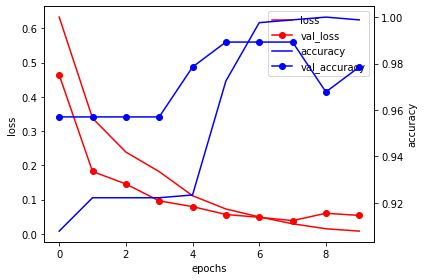

In [52]:
# посмотрим на историю обучения

fig, ax1 = plt.subplots()

t = np.arange(0, len(r.history['accuracy']), 1)

ln1 = ax1.plot(t, r.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, r.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, r.history['accuracy'], color='b', label='accuracy')
ln4 = ax2.plot(t, r.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [53]:
p = model.predict(x_test)

print('NN acc, f1, roc_auc: ', accuracy_score(y_true=list(y_test[:,1]), y_pred=list(np.round(p[:,1]))),
    f1_score(y_true=list(y_test[:,1]), y_pred=list(np.round(p[:,1]))),
    roc_auc_score(y_true=list(y_test[:,1]), y_score=list(np.round(p[:,1]))))

NN acc, f1, roc_auc:  0.978494623655914 0.8 0.9887640449438202


In [54]:
test_text = 'да'
print(np.max(model.predict(pad_sequences([preprocess(test_text)], maxlen=MAX_SEQ_LEN))), 
np.argmax(model.predict(pad_sequences([preprocess(test_text)], maxlen=MAX_SEQ_LEN))))

0.966852 1


In [55]:
test_text = 'нет'
print(np.max(model.predict(pad_sequences([preprocess(test_text)], maxlen=MAX_SEQ_LEN))), 
np.argmax(model.predict(pad_sequences([preprocess(test_text)], maxlen=MAX_SEQ_LEN))))

0.9921738 0


In [56]:
test_text = 'узнать расписание занятий'
print(np.max(model.predict(pad_sequences([preprocess(test_text)], maxlen=MAX_SEQ_LEN))), 
np.argmax(model.predict(pad_sequences([preprocess(test_text)], maxlen=MAX_SEQ_LEN))))

0.9999614 0


In [57]:
model.save(r'C:\Users\vndan\projects\netology_chat_bot\models\NN_classification_yesno.hdf5')